# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print("High correlations:")
print(correlations.dropna().sort_values(ascending=False).head(10))
print("\nLow correlations:")
print(correlations.dropna().sort_values(ascending=False).tail(10))

High correlations:
sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
Name: sat_score, dtype: float64

Low correlations:
male_per       -0.112062
com_p_11       -0.115073
lat            -0.121029
lon            -0.132222
ell_num        -0.153778
black_per      -0.284139
hispanic_per   -0.396985
ell_percent    -0.398750
sped_percent   -0.448170
frl_percent    -0.722225
Name: sat_score, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Starting analysis

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

(67,)


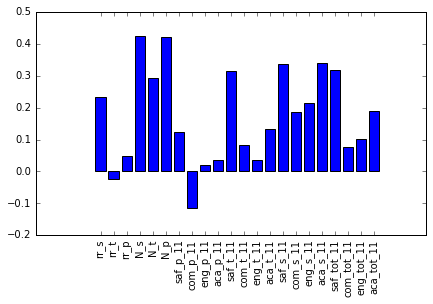

In [12]:
print(correlations.shape)

fig, ax = plt.subplots(figsize=(7,4))
len_survey = len(survey_fields)

corr_survey = correlations.loc[survey_fields]
_ = ax.bar(range(len_survey), height=corr_survey, align='center')
_ = ax.set_xticks(range(0,len_survey))
_ = ax.set_xticklabels(survey_fields, rotation=90)

The highest correlations are for N_s and N_p. The zip file with the dictionary has moved location so we do not know exactly what they mean.

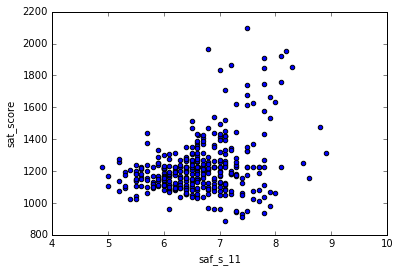

In [13]:
combined.plot("saf_s_11", "sat_score", kind="scatter")

We see above that a high safety score correlates positively with the sat_scores.

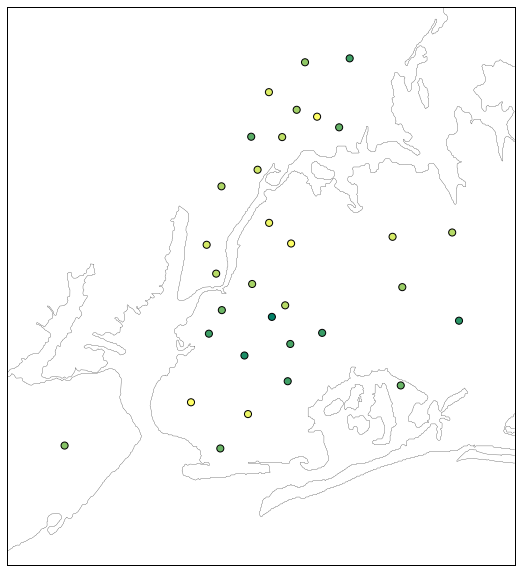

In [14]:
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(projection='merc'
            ,llcrnrlat=40.51,llcrnrlon=-74.18
            ,urcrnrlat=40.91, urcrnrlon=-73.7
            ,resolution='f')
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

#print(combined.columns)
districts = combined.groupby("school_dist").agg(numpy.mean)
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, latlon=True
          , s=50, zorder=2, c=districts["saf_s_11"], cmap="summer")

plt.show()

We see that the neighborhoods with lower values for safety metric *saf_s_11* are in areas of the Bronx and Brooklyn.

There are a few columns that indicate the percentage of each race at a given school:
- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

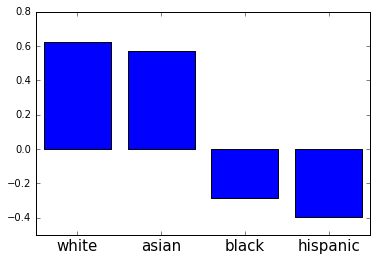

In [32]:
races_per = ["white_per", "asian_per", "black_per", "hispanic_per"]
fig, ax = plt.subplots()
_ = ax.bar( range(len(races_per)), correlations[races_per], align='center' )
_ = ax.set_xticks(range(4))
_ = ax.set_ylim(-0.5, 0.8)
_ = ax.set_xticklabels( (x.replace("_per", "") for x in races_per), fontsize=15)

Notice how poorly the hispanic percentage correlates with sat scores. Let's investigate this further:

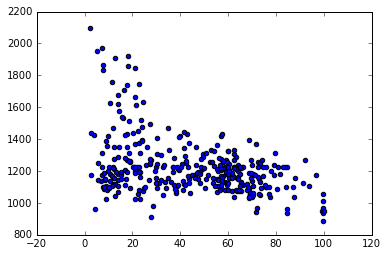

In [36]:
plt.scatter("hispanic_per", "sat_score", data=combined)

Indeed, sat scores follow a decreasing line dependent on hispanic percentage. Furthermore, we see that schools with very high percentage of hispanics scores extremely poorly (<1000), while those with very low percentages have a wider distribution that includes very high values (>1800)

In [40]:
print(combined.loc[ combined['hispanic_per']>95, "SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Several of the schools above cater to immigrants recently arrived from spanish-speakingn countries.

In [41]:
print(combined.loc[ (combined['hispanic_per']<10) 
                   & (combined["sat_score"]>1800), "SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Brooklyn Tech, Stuyvesant and Bronx High School of Science are 3 specialized high schools that are operated by the NYC Department of Education. They are prestigious and admission is highly competitive.  The other 2 are also prestigious, well-funded schools.

The very low percentage of hispanics suggests that demographic either is unfairly selected out, or lacks the priviliged conditions that correlate with higher admissions scores (e.g. quality of elementary and middle education among other socio-economic factors).

# Gender differences in the SAT

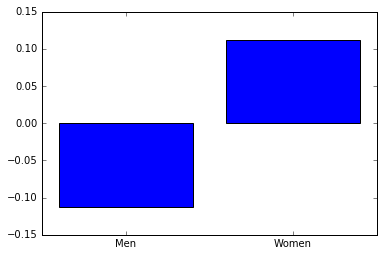

In [44]:
fig, ax = plt.subplots()

_ = ax.bar( [1,2], correlations[["male_per", "female_per"]], align='center')
_ = ax.set_xticks( [1,2] )
_ = ax.set_xticklabels( ["Men", "Women"] )



Seems there's a slight correlation between gender and SAT scores.

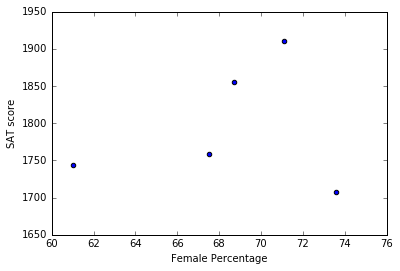

In [50]:
fig, ax = plt.subplots()

df_high_female_sat = combined.loc[ (combined["female_per"]>60 )
                             & (combined["sat_score"]>1700), :]
_ = ax.scatter( df_high_female_sat['female_per']
               , df_high_female_sat['sat_score'] )
_ = ax.set_xlabel('Female Percentage')
_ = ax.set_ylabel('SAT score')

There are several very high performing schools with a very high percentage of females. These schools are

In [51]:
print(df_high_female_sat['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# Advance Placement and the SAT
In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [52]:
combined['ap_per'] = (combined['AP Test Takers '] 
                      / combined['total_enrollment'])

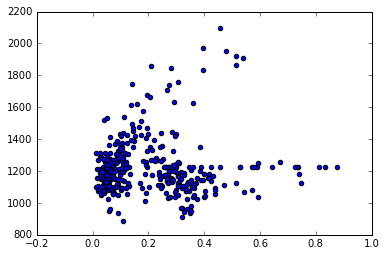

In [53]:
fig, ax = plt.subplots()

_ = ax.scatter( combined['ap_per'], combined['sat_score'] )